In [1]:
%run ~/CPPN/utils.py
from torch_geometric.datasets import ZINC


In [2]:
class CPPN(torch.nn.Module):
    
    def __init__(self, in_feats, num_classes = None, num_layers = 2, num_hidden = 128, dropout = 0.1):
        super(CPPN, self).__init__()
        
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.in_feats = in_feats
        self.num_classes = num_classes
        self.dropout = dropout
        
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(self.in_feats, self.num_hidden))
        # self.class_layer_zero = torch.nn.Linear(self.num_hidden, self.num_hidden)
        # self.class_layer = torch.nn.Linear(self.num_hidden, self.num_classes)
        
        for _ in range(self.num_layers - 2):
            self.lins.append(torch.nn.Linear(self.num_hidden, self.num_hidden))
            
        self.lins.append(torch.nn.Linear(self.num_hidden, 1))
    
    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
            
    def forward(self, x):
        
        for idx, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            x = F.dropout(x, p = self.dropout, training = self.training)
            x = F.relu(x)

        # c = self.class_layer_zero(x)
        # c = self.class_layer(c)
        
        x = self.lins[-1](x)
        
        return x #torch.sigmoid(x)

In [3]:
z = ZINC(root = './data', subset = True)

In [19]:
z_test = ZINC(root = './data', subset = True, split = 'test')

In [40]:
mol_loss = []

cppn = CPPN(in_feats = 61, #num_feats + context.shape[0],
                num_layers = 6,
                num_classes = 0,
                num_hidden = 512,
                dropout = 0.3).to(device)
    
optimizer = optim.Adam(cppn.parameters(),
                       lr = 1e-4,
                       weight_decay = 1e-7)
cppn.train()

for z_idx in range(10):
    
    edge_list = z[z_idx].edge_index.detach().cpu().numpy()
    graph = nx.from_edgelist([(edge_list[0][idx], edge_list[1][idx]) for idx in range(edge_list.shape[1])])
    adj = torch.Tensor(nx.to_numpy_array(graph)).to(device)

    # Curvature
    deg = torch.sum(adj, axis = 1)
    curv = 4 - deg.unsqueeze(1) - deg.unsqueeze(0)

    # Hop Distance 
    len_adj = []
    for n in tqdm(graph.nodes):
        lengths = dict(nx.single_source_dijkstra_path_length(graph, n))
        len_adj.append(np.array(list(dict(sorted(lengths.items(), key = lambda item: item[0])).values())))
    len_adj = np.array(len_adj)
    
    
    # core_nodes = list(nx.k_core(graph).nodes)
    # core_lengths = np.array([[nx.shortest_path_length(graph, i, n) for n in core_nodes] for i in tqdm(range(len(graph)))])
    # norm_core_lengths = (core_lengths - np.min(core_lengths)) / np.ptp(core_lengths)
    
    f = z[z_idx].x.detach().cpu().flatten().numpy()
    f = (f - np.min(f)) / np.ptp(f)

    # os.remove('_.pkl')
    # dgi = DGIEmbedding(graph = graph, 
    #            embed_dim = 8, 
    #            feature_matrix = f.reshape(-1, 1), 
    #            batch_size = 1, 
    #            patience = 30,
    #            model_name = '_')
    
    # dgi.embed()
    # embed = dgi.get_embedding()
    # context = np.mean(embed, axis = 0)

    node_features = F.one_hot(z[z_idx].x, num_classes = 21).detach().cpu().numpy()
    edge_features = F.one_hot(z[z_idx].edge_attr, num_classes = 4).detach().cpu().numpy()

    # Coordinates
    x_mat = np.tile((np.arange(adj.shape[0]) / adj.shape[0]), (adj.shape[0], 1)).T 
    y_mat = np.tile((np.arange(adj.shape[1]) / adj.shape[1]), (adj.shape[1], 1)).T 
    
    # Node Features
    # np_feat = (features @ features.T).detach().cpu().numpy()
    # np_feat = (np_feat - np.min(np_feat)) / np.ptp(np_feat)
    node_feat_map = np.zeros((adj.shape[0], adj.shape[1], 2 * node_features.shape[-1]))
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            node_feat_map[i][j] = np.hstack([node_features[0], node_features[1]])
    
    edge_feat_map = np.zeros((adj.shape[0], adj.shape[1], edge_features.shape[-1]))
    for i in range(edge_list.shape[1]):
        edge_feat_map[edge_list[0][i]][edge_list[1][i]] = edge_features[i]
            
    
    # Hop Length 
    norm_len_adj = (len_adj - np.min(len_adj)) / np.ptp(len_adj)
    
    # Input Matrix
    # norm_len_adj
    in_mat = np.stack([x_mat, y_mat, norm_len_adj],
                      -1)
    # in_mat = np.stack([x_mat, y_mat, norm_len_adj] +\
    #                   [np.ones((adj.shape[0], adj.shape[0])) * context[i] for i in range(context.shape[0])],
    #                   -1)
    
    # Structural Features 
    sense_feat_dict, sense_features = get_sense_features(graph)
    feat_map = np.zeros((sense_features.shape[0], sense_features.shape[0], 2 * sense_features.shape[1]))
    for i in range(sense_features.shape[0]):
        for j in range(sense_features.shape[0]):
            feat_map[i, j, :] = np.concatenate([sense_features[i], sense_features[j]])
    
    # Lengths to Core Nodes
    # core_map = np.zeros((norm_core_lengths.shape[0], norm_core_lengths.shape[0], 2 * norm_core_lengths.shape[1]))
    # for i in range(norm_core_lengths.shape[0]):
    #     for j in range(norm_core_lengths.shape[0]):
    #         core_map[i, j, :] = np.concatenate([norm_core_lengths[i], norm_core_lengths[j]])
    
    in_mat = np.concatenate([in_mat, feat_map, edge_feat_map, node_feat_map], axis = -1)
    # in_mat = np.concatenate([in_mat, core_map], axis = -1)
    
    in_mat = torch.Tensor(in_mat)
    in_mat = in_mat.to(device)
    
    
    num_feats = 3 + feat_map.shape[-1] + edge_feat_map.shape[-1] + node_feat_map.shape[-1]
    
    for e in range(2000):
        optimizer.zero_grad()
        out = cppn(in_mat)
        out = out.reshape(adj.shape[0], adj.shape[0])
        out = (out + out.T) / 2
        recon_adj = out 
        recon_deg = torch.sum(recon_adj, axis = 1)
        recon_curv = 4 - recon_deg.unsqueeze(1) - recon_deg.unsqueeze(0)

        curv_loss = torch.sum(torch.square(recon_curv - curv))
        
        # out_list.append(out.detach().cpu().numpy())
        diff = out - adj
        #diff = diff[r, c]
        edge_loss = torch.sum(torch.square(diff)) 
        loss = edge_loss + (1e-2 * curv_loss) 
        loss.backward()
        optimizer.step()
        print ("Epoch : ", e, "Loss : ", loss.item(), end = '\r') #, "(Class Loss : ", class_loss.item(), ")", end = '\r')
    print ("Molecule ", z_idx, " | Loss : ", loss.item())
    mol_loss.append(loss.item())

    # if z_idx % 10 == 0:
    #     torch.save(cppn.state_dict(), './cppn.pkl')

100%|██████████| 29/29 [00:00<00:00, 19650.21it/s]


Molecule  0  | Loss :  22.19256591796875                  


100%|██████████| 26/26 [00:00<00:00, 20548.69it/s]

Molecule  1  | Loss :  10.675187110900879


100%|██████████| 16/16 [00:00<00:00, 28032.11it/s]

Molecule  2  | Loss :  1.1640872955322266


100%|██████████| 27/27 [00:00<00:00, 20251.47it/s]

Molecule  3  | Loss :  2.1638927459716797


100%|██████████| 21/21 [00:00<00:00, 23658.44it/s]

Molecule  4  | Loss :  0.5277684330940247


100%|██████████| 28/28 [00:00<00:00, 20161.46it/s]

Molecule  5  | Loss :  2.4018044471740723


100%|██████████| 19/19 [00:00<00:00, 25115.59it/s]

Molecule  6  | Loss :  0.28253424167633057


100%|██████████| 16/16 [00:00<00:00, 28020.40it/s]

Molecule  7  | Loss :  0.078228332102298741251 Loss :  0.17160101234912872


100%|██████████| 22/22 [00:00<00:00, 24276.42it/s]

Molecule  8  | Loss :  0.2986132502555847


100%|██████████| 18/18 [00:00<00:00, 28739.05it/s]

Molecule  9  | Loss :  0.45997270941734314


In [41]:
recon_adj = out 
best_diff = np.inf
best_t = None
for t in np.arange(100) / 100: 
    recon_deg = torch.sum(recon_adj > t, axis = 1)
    recon_curv = 4 - recon_deg.unsqueeze(1) - recon_deg.unsqueeze(0)
    c_diff = torch.sum(torch.abs(recon_curv - curv))
    if c_diff < best_diff: 
        best_diff = c_diff
        best_t = t

recon_deg = torch.sum(recon_adj > best_t, axis = 1)
recon_curv = 4 - recon_deg.unsqueeze(1) - recon_deg.unsqueeze(0)
# recon_curv = (recon_curv - torch.min(recon_curv)) / (torch.max(recon_curv) - torch.min(recon_curv))


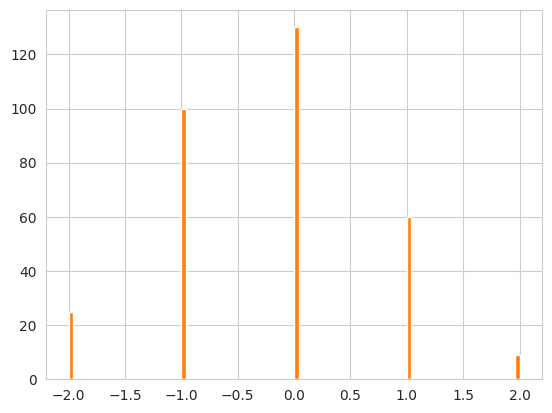

In [42]:
plt.hist(curv.detach().cpu().numpy().flatten(), bins = 100)
plt.hist(recon_curv.detach().cpu().numpy().flatten(), bins = 100)

plt.show()

In [46]:
cppn = CPPN(in_feats = 61, 
                num_layers = 6,
                num_classes = 0,
                num_hidden = 512,
                dropout = 0.1).to(device)
cppn.load_state_dict(torch.load('./cppn.pkl'))
cppn.eval()

diff_list = []
for z_idx in range(1000):
    
    edge_list = z_test[z_idx].edge_index.detach().cpu().numpy()
    graph = nx.from_edgelist([(edge_list[0][idx], edge_list[1][idx]) for idx in range(edge_list.shape[1])])
    adj = torch.Tensor(nx.to_numpy_array(graph)).to(device)

    # Hop Distance 
    len_adj = []
    for n in tqdm(graph.nodes):
        lengths = dict(nx.single_source_dijkstra_path_length(graph, n))
        len_adj.append(np.array(list(dict(sorted(lengths.items(), key = lambda item: item[0])).values())))
    len_adj = np.array(len_adj)
    
    
 
    f = z_test[z_idx].x.detach().cpu().flatten().numpy()
    f = (f - np.min(f)) / np.ptp(f)

    node_features = F.one_hot(z_test[z_idx].x, num_classes = 21).detach().cpu().numpy()
    edge_features = F.one_hot(z_test[z_idx].edge_attr, num_classes = 4).detach().cpu().numpy()

    # Coordinates
    x_mat = np.tile((np.arange(adj.shape[0]) / adj.shape[0]), (adj.shape[0], 1)).T 
    y_mat = np.tile((np.arange(adj.shape[1]) / adj.shape[1]), (adj.shape[1], 1)).T 
    
    # Node Features
    node_feat_map = np.zeros((adj.shape[0], adj.shape[1], 2 * node_features.shape[-1]))
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            node_feat_map[i][j] = np.hstack([node_features[0], node_features[1]])
    
    edge_feat_map = np.zeros((adj.shape[0], adj.shape[1], edge_features.shape[-1]))
    for i in range(edge_list.shape[1]):
        edge_feat_map[edge_list[0][i]][edge_list[1][i]] = edge_features[i]
            
    
    # Hop Length 
    norm_len_adj = (len_adj - np.min(len_adj)) / np.ptp(len_adj)
    
    # Input Matrix
    in_mat = np.stack([x_mat, y_mat, norm_len_adj],
                      -1)

    
    # Structural Features 
    sense_feat_dict, sense_features = get_sense_features(graph)
    feat_map = np.zeros((sense_features.shape[0], sense_features.shape[0], 2 * sense_features.shape[1]))
    for i in range(sense_features.shape[0]):
        for j in range(sense_features.shape[0]):
            feat_map[i, j, :] = np.concatenate([sense_features[i], sense_features[j]])
    
    in_mat = np.concatenate([in_mat, feat_map, edge_feat_map, node_feat_map], axis = -1)    
    in_mat = torch.Tensor(in_mat)
    in_mat = in_mat.to(device)
    
    
    num_feats = 3 + feat_map.shape[-1] + edge_feat_map.shape[-1] + node_feat_map.shape[-1]

    
    out = cppn(in_mat)
    out = out.reshape(adj.shape[0], adj.shape[0])
    out = (out + out.T) / 2
    diff = torch.sum(torch.square(out - adj))
    diff_list.append(diff.item())
    # print ("Molecule", z_idx, " | Loss : ", diff.item())

100%|██████████| 16/16 [00:00<00:00, 28244.47it/s]


100%|██████████| 23/23 [00:00<00:00, 22274.07it/s]


100%|██████████| 24/24 [00:00<00:00, 22723.09it/s]


100%|██████████| 22/22 [00:00<00:00, 24725.26it/s]


100%|██████████| 20/20 [00:00<00:00, 17509.10it/s]


100%|██████████| 23/23 [00:00<00:00, 22618.76it/s]


100%|██████████| 16/16 [00:00<00:00, 24537.06it/s]


100%|██████████| 22/22 [00:00<00:00, 20961.99it/s]


100%|██████████| 18/18 [00:00<00:00, 24440.75it/s]


100%|██████████| 23/23 [00:00<00:00, 21229.97it/s]


100%|██████████| 26/26 [00:00<00:00, 21441.59it/s]


100%|██████████| 21/21 [00:00<00:00, 24776.48it/s]


100%|██████████| 23/23 [00:00<00:00, 19968.74it/s]


100%|██████████| 23/23 [00:00<00:00, 23609.64it/s]


100%|██████████| 26/26 [00:00<00:00, 21203.95it/s]


100%|██████████| 28/28 [00:00<00:00, 19606.10it/s]


100%|██████████| 29/29 [00:00<00:00, 19020.30it/s]


100%|██████████| 26/26 [00:00<00:00, 20783.67it/s]


100%|██████████| 23/23 [00:00<00:00, 22055.10it/s]


100%|██████████| 18/18 [00:00<00:00, 26791.15it/s]


100%|██████████| 20/20 [00:00<00:00, 13519.11it/s]


100%|██████████| 29/29 [00:00<00:00, 19442.91it/s]


100%|██████████| 12/12 [00:00<00:00, 35797.76it/s]


100%|██████████| 20/20 [00:00<00:00, 23039.30it/s]


100%|██████████| 25/25 [00:00<00:00, 19639.93it/s]


100%|██████████| 24/24 [00:00<00:00, 20148.78it/s]


100%|██████████| 27/27 [00:00<00:00, 20703.15it/s]


100%|██████████| 31/31 [00:00<00:00, 18513.94it/s]


100%|██████████| 23/23 [00:00<00:00, 23375.09it/s]


100%|██████████| 24/24 [00:00<00:00, 22474.50it/s]


100%|██████████| 20/20 [00:00<00:00, 25085.55it/s]


100%|██████████| 27/27 [00:00<00:00, 20515.62it/s]


100%|██████████| 22/22 [00:00<00:00, 24619.71it/s]


100%|██████████| 22/22 [00:00<00:00, 24398.38it/s]


100%|██████████| 16/16 [00:00<00:00, 30053.23it/s]


100%|██████████| 27/27 [00:00<00:00, 17109.26it/s]


100%|██████████| 25/25 [00:00<00:00, 21813.52it/s]


100%|██████████| 30/30 [00:00<00:00, 18104.91it/s]


100%|██████████| 22/22 [00:00<00:00, 20204.66it/s]


100%|██████████| 21/21 [00:00<00:00, 25037.06it/s]


100%|██████████| 33/33 [00:00<00:00, 15701.88it/s]


100%|██████████| 23/23 [00:00<00:00, 23341.15it/s]


100%|██████████| 23/23 [00:00<00:00, 23848.95it/s]


100%|██████████| 25/25 [00:00<00:00, 21571.20it/s]


100%|██████████| 19/19 [00:00<00:00, 24611.42it/s]


100%|██████████| 27/27 [00:00<00:00, 18303.90it/s]


100%|██████████| 27/27 [00:00<00:00, 19944.74it/s]


100%|██████████| 25/25 [00:00<00:00, 21351.58it/s]


100%|██████████| 26/26 [00:00<00:00, 21270.12it/s]


100%|██████████| 16/16 [00:00<00:00, 27639.57it/s]


100%|██████████| 27/27 [00:00<00:00, 18200.93it/s]


100%|██████████| 19/19 [00:00<00:00, 26440.54it/s]


100%|██████████| 28/28 [00:00<00:00, 19744.54it/s]


100%|██████████| 23/23 [00:00<00:00, 22941.50it/s]


100%|██████████| 25/25 [00:00<00:00, 19548.40it/s]


100%|██████████| 17/17 [00:00<00:00, 27530.18it/s]


100%|██████████| 19/19 [00:00<00:00, 19451.25it/s]


100%|██████████| 21/21 [00:00<00:00, 24098.60it/s]


100%|██████████| 26/26 [00:00<00:00, 18870.38it/s]


100%|██████████| 22/22 [00:00<00:00, 22043.64it/s]


100%|██████████| 19/19 [00:00<00:00, 27041.66it/s]


100%|██████████| 20/20 [00:00<00:00, 23689.94it/s]


100%|██████████| 21/21 [00:00<00:00, 22619.51it/s]


100%|██████████| 21/21 [00:00<00:00, 25108.43it/s]


100%|██████████| 28/28 [00:00<00:00, 20325.46it/s]


100%|██████████| 19/19 [00:00<00:00, 26688.47it/s]


100%|██████████| 27/27 [00:00<00:00, 20265.96it/s]


100%|██████████| 21/21 [00:00<00:00, 23709.39it/s]


100%|██████████| 20/20 [00:00<00:00, 23723.44it/s]


100%|██████████| 19/19 [00:00<00:00, 22136.60it/s]


100%|██████████| 28/28 [00:00<00:00, 18390.31it/s]


100%|██████████| 25/25 [00:00<00:00, 21745.67it/s]


100%|██████████| 28/28 [00:00<00:00, 20099.35it/s]


100%|██████████| 22/22 [00:00<00:00, 21620.12it/s]


100%|██████████| 21/21 [00:00<00:00, 21678.66it/s]


100%|██████████| 25/25 [00:00<00:00, 20432.11it/s]


100%|██████████| 20/20 [00:00<00:00, 23797.47it/s]


100%|██████████| 23/23 [00:00<00:00, 21929.75it/s]


100%|██████████| 19/19 [00:00<00:00, 22588.37it/s]


100%|██████████| 15/15 [00:00<00:00, 26978.80it/s]


100%|██████████| 22/22 [00:00<00:00, 20378.69it/s]


100%|██████████| 12/12 [00:00<00:00, 30690.03it/s]


100%|██████████| 20/20 [00:00<00:00, 22441.43it/s]

Calculating Degrees...                                   

100%|██████████| 24/24 [00:00<00:00, 19870.37it/s]


100%|██████████| 27/27 [00:00<00:00, 18880.66it/s]


100%|██████████| 23/23 [00:00<00:00, 22171.68it/s]


100%|██████████| 18/18 [00:00<00:00, 24440.75it/s]


100%|██████████| 19/19 [00:00<00:00, 22486.39it/s]


100%|██████████| 28/28 [00:00<00:00, 17057.45it/s]


100%|██████████| 22/22 [00:00<00:00, 22358.78it/s]


100%|██████████| 20/20 [00:00<00:00, 23649.87it/s]


100%|██████████| 20/20 [00:00<00:00, 24506.60it/s]


100%|██████████| 27/27 [00:00<00:00, 17797.61it/s]


100%|██████████| 17/17 [00:00<00:00, 24913.76it/s]


100%|██████████| 17/17 [00:00<00:00, 22521.53it/s]


100%|██████████| 21/21 [00:00<00:00, 21641.37it/s]


100%|██████████| 19/19 [00:00<00:00, 23480.19it/s]


100%|██████████| 22/22 [00:00<00:00, 21891.98it/s]


100%|██████████| 18/18 [00:00<00:00, 24949.59it/s]


100%|██████████| 18/18 [00:00<00:00, 23763.76it/s]


100%|██████████| 25/25 [00:00<00:00, 18431.64it/s]


100%|██████████| 26/26 [00:00<00:00, 20086.92it/s]


100%|██████████| 20/20 [00:00<00:00, 24160.74it/s]


100%|██████████| 25/25 [00:00<00:00, 19187.12it/s]


100%|██████████| 26/26 [00:00<00:00, 19712.93it/s]


100%|██████████| 15/15 [00:00<00:00, 27887.66it/s]


100%|██████████| 20/20 [00:00<00:00, 21704.03it/s]


100%|██████████| 19/19 [00:00<00:00, 23254.09it/s]


100%|██████████| 27/27 [00:00<00:00, 18084.67it/s]


100%|██████████| 20/20 [00:00<00:00, 23490.92it/s]


100%|██████████| 25/25 [00:00<00:00, 15240.93it/s]


100%|██████████| 18/18 [00:00<00:00, 24999.16it/s]


100%|██████████| 23/23 [00:00<00:00, 19756.09it/s]


100%|██████████| 32/32 [00:00<00:00, 17060.85it/s]


100%|██████████| 13/13 [00:00<00:00, 28473.08it/s]


100%|██████████| 27/27 [00:00<00:00, 17481.66it/s]


100%|██████████| 22/22 [00:00<00:00, 22133.53it/s]


100%|██████████| 28/28 [00:00<00:00, 19625.75it/s]


100%|██████████| 18/18 [00:00<00:00, 25740.70it/s]


100%|██████████| 26/26 [00:00<00:00, 18025.11it/s]


100%|██████████| 25/25 [00:00<00:00, 21059.97it/s]


100%|██████████| 17/17 [00:00<00:00, 25213.28it/s]


100%|██████████| 32/32 [00:00<00:00, 15846.25it/s]


100%|██████████| 20/20 [00:00<00:00, 24286.65it/s]


100%|██████████| 22/22 [00:00<00:00, 20186.98it/s]

Calculating Degrees...                                   

100%|██████████| 18/18 [00:00<00:00, 25811.10it/s]


100%|██████████| 19/19 [00:00<00:00, 22678.37it/s]


100%|██████████| 17/17 [00:00<00:00, 23571.30it/s]


100%|██████████| 24/24 [00:00<00:00, 19336.02it/s]


100%|██████████| 27/27 [00:00<00:00, 19178.02it/s]


100%|██████████| 23/23 [00:00<00:00, 21008.06it/s]


100%|██████████| 25/25 [00:00<00:00, 20095.36it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 22358.78it/s]


100%|██████████| 27/27 [00:00<00:00, 19266.11it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 21584.72it/s]


100%|██████████| 25/25 [00:00<00:00, 20412.23it/s]


100%|██████████| 23/23 [00:00<00:00, 22095.51it/s]


100%|██████████| 19/19 [00:00<00:00, 25163.18it/s]


100%|██████████| 21/21 [00:00<00:00, 23277.06it/s]


100%|██████████| 19/19 [00:00<00:00, 23967.45it/s]


100%|██████████| 21/21 [00:00<00:00, 23252.48it/s]


100%|██████████| 21/21 [00:00<00:00, 21530.28it/s]


100%|██████████| 15/15 [00:00<00:00, 24633.74it/s]


100%|██████████| 33/33 [00:00<00:00, 15510.09it/s]


100%|██████████| 19/19 [00:00<00:00, 23411.22it/s]


100%|██████████| 31/31 [00:00<00:00, 16263.09it/s]


100%|██████████| 25/25 [00:00<00:00, 20641.26it/s]


100%|██████████| 21/21 [00:00<00:00, 22848.35it/s]


100%|██████████| 20/20 [00:00<00:00, 24015.48it/s]


100%|██████████| 28/28 [00:00<00:00, 16949.13it/s]


100%|██████████| 24/24 [00:00<00:00, 21458.81it/s]


100%|██████████| 18/18 [00:00<00:00, 24283.52it/s]


100%|██████████| 36/36 [00:00<00:00, 13544.58it/s]


100%|██████████| 23/23 [00:00<00:00, 20516.59it/s]


100%|██████████| 23/23 [00:00<00:00, 19076.33it/s]


100%|██████████| 27/27 [00:00<00:00, 16754.88it/s]

Calculating Degrees...                                   

100%|██████████| 25/25 [00:00<00:00, 19866.92it/s]


100%|██████████| 31/31 [00:00<00:00, 17480.97it/s]


100%|██████████| 23/23 [00:00<00:00, 21428.03it/s]


100%|██████████| 29/29 [00:00<00:00, 18335.06it/s]


100%|██████████| 23/23 [00:00<00:00, 21712.58it/s]


100%|██████████| 25/25 [00:00<00:00, 20056.92it/s]


100%|██████████| 30/30 [00:00<00:00, 18710.65it/s]


100%|██████████| 30/30 [00:00<00:00, 18204.44it/s]


100%|██████████| 25/25 [00:00<00:00, 20726.94it/s]


100%|██████████| 23/23 [00:00<00:00, 21229.97it/s]


100%|██████████| 25/25 [00:00<00:00, 20958.94it/s]


100%|██████████| 20/20 [00:00<00:00, 23140.99it/s]


100%|██████████| 24/24 [00:00<00:00, 17962.76it/s]


100%|██████████| 29/29 [00:00<00:00, 18661.37it/s]


100%|██████████| 13/13 [00:00<00:00, 27692.21it/s]


100%|██████████| 19/19 [00:00<00:00, 20517.96it/s]


100%|██████████| 22/22 [00:00<00:00, 21819.51it/s]


100%|██████████| 22/22 [00:00<00:00, 22181.42it/s]


100%|██████████| 24/24 [00:00<00:00, 21032.87it/s]


100%|██████████| 24/24 [00:00<00:00, 21349.59it/s]


100%|██████████| 19/19 [00:00<00:00, 24756.69it/s]


100%|██████████| 23/23 [00:00<00:00, 21413.76it/s]

Calculating Degrees...                                   

100%|██████████| 27/27 [00:00<00:00, 20211.71it/s]


100%|██████████| 25/25 [00:00<00:00, 20480.00it/s]


100%|██████████| 13/13 [00:00<00:00, 27100.37it/s]


100%|██████████| 21/21 [00:00<00:00, 19077.41it/s]


100%|██████████| 18/18 [00:00<00:00, 22496.27it/s]

Calculating Degrees...                                   

100%|██████████| 23/23 [00:00<00:00, 19023.66it/s]


100%|██████████| 19/19 [00:00<00:00, 24452.83it/s]


100%|██████████| 20/20 [00:00<00:00, 21215.50it/s]


100%|██████████| 26/26 [00:00<00:00, 18175.32it/s]


100%|██████████| 13/13 [00:00<00:00, 29065.01it/s]


100%|██████████| 26/26 [00:00<00:00, 18430.27it/s]


100%|██████████| 16/16 [00:00<00:00, 24763.42it/s]


100%|██████████| 27/27 [00:00<00:00, 18162.98it/s]


100%|██████████| 18/18 [00:00<00:00, 24941.35it/s]


100%|██████████| 19/19 [00:00<00:00, 22814.71it/s]


100%|██████████| 24/24 [00:00<00:00, 18504.28it/s]


100%|██████████| 22/22 [00:00<00:00, 20606.23it/s]


100%|██████████| 21/21 [00:00<00:00, 20705.31it/s]


100%|██████████| 24/24 [00:00<00:00, 17744.28it/s]


100%|██████████| 31/31 [00:00<00:00, 17338.77it/s]


100%|██████████| 14/14 [00:00<00:00, 25321.37it/s]


100%|██████████| 23/23 [00:00<00:00, 19083.88it/s]


100%|██████████| 29/29 [00:00<00:00, 18412.78it/s]


100%|██████████| 27/27 [00:00<00:00, 19923.68it/s]


100%|██████████| 21/21 [00:00<00:00, 23928.38it/s]


100%|██████████| 26/26 [00:00<00:00, 20086.92it/s]


100%|██████████| 11/11 [00:00<00:00, 30234.17it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 20320.35it/s]


100%|██████████| 27/27 [00:00<00:00, 19815.61it/s]


100%|██████████| 26/26 [00:00<00:00, 18157.16it/s]


100%|██████████| 22/22 [00:00<00:00, 22064.73it/s]


100%|██████████| 17/17 [00:00<00:00, 26896.71it/s]


100%|██████████| 19/19 [00:00<00:00, 21631.86it/s]


100%|██████████| 24/24 [00:00<00:00, 19784.45it/s]


100%|██████████| 22/22 [00:00<00:00, 22434.89it/s]


100%|██████████| 14/14 [00:00<00:00, 25822.45it/s]


100%|██████████| 24/24 [00:00<00:00, 17650.94it/s]


100%|██████████| 29/29 [00:00<00:00, 17165.51it/s]


100%|██████████| 24/24 [00:00<00:00, 19953.08it/s]


100%|██████████| 31/31 [00:00<00:00, 16976.55it/s]


100%|██████████| 33/33 [00:00<00:00, 16432.63it/s]


100%|██████████| 24/24 [00:00<00:00, 20615.05it/s]


100%|██████████| 19/19 [00:00<00:00, 24266.68it/s]


100%|██████████| 15/15 [00:00<00:00, 24720.85it/s]


100%|██████████| 29/29 [00:00<00:00, 16639.51it/s]


100%|██████████| 28/28 [00:00<00:00, 18817.58it/s]


100%|██████████| 21/21 [00:00<00:00, 22310.13it/s]


100%|██████████| 22/22 [00:00<00:00, 22181.42it/s]


100%|██████████| 19/19 [00:00<00:00, 21875.32it/s]


100%|██████████| 31/31 [00:00<00:00, 15756.60it/s]


100%|██████████| 17/17 [00:00<00:00, 25465.42it/s]

Calculating Degrees...                                   

100%|██████████| 28/28 [00:00<00:00, 17414.07it/s]


100%|██████████| 28/28 [00:00<00:00, 17864.39it/s]


100%|██████████| 23/23 [00:00<00:00, 20921.49it/s]


100%|██████████| 21/21 [00:00<00:00, 24085.42it/s]


100%|██████████| 20/20 [00:00<00:00, 19359.82it/s]


100%|██████████| 20/20 [00:00<00:00, 21415.90it/s]


100%|██████████| 21/21 [00:00<00:00, 19722.43it/s]


100%|██████████| 23/23 [00:00<00:00, 21123.05it/s]


100%|██████████| 29/29 [00:00<00:00, 18893.26it/s]


100%|██████████| 15/15 [00:00<00:00, 28036.79it/s]


100%|██████████| 25/25 [00:00<00:00, 18965.02it/s]


100%|██████████| 24/24 [00:00<00:00, 20364.82it/s]


100%|██████████| 25/25 [00:00<00:00, 19155.57it/s]


100%|██████████| 25/25 [00:00<00:00, 21273.61it/s]


100%|██████████| 23/23 [00:00<00:00, 22136.07it/s]


100%|██████████| 21/21 [00:00<00:00, 21244.67it/s]


100%|██████████| 20/20 [00:00<00:00, 24272.59it/s]


100%|██████████| 30/30 [00:00<00:00, 17980.73it/s]


100%|██████████| 25/25 [00:00<00:00, 20641.26it/s]


100%|██████████| 26/26 [00:00<00:00, 20116.57it/s]


100%|██████████| 22/22 [00:00<00:00, 22644.10it/s]


100%|██████████| 26/26 [00:00<00:00, 19456.18it/s]


100%|██████████| 32/32 [00:00<00:00, 17238.34it/s]


100%|██████████| 23/23 [00:00<00:00, 21860.18it/s]


100%|██████████| 22/22 [00:00<00:00, 21615.06it/s]


100%|██████████| 26/26 [00:00<00:00, 18163.21it/s]


100%|██████████| 24/24 [00:00<00:00, 22162.77it/s]


100%|██████████| 26/26 [00:00<00:00, 19550.36it/s]


100%|██████████| 19/19 [00:00<00:00, 24772.08it/s]

Calculating Degrees...                                   

100%|██████████| 24/24 [00:00<00:00, 20556.12it/s]


100%|██████████| 28/28 [00:00<00:00, 18154.35it/s]


100%|██████████| 21/21 [00:00<00:00, 23087.91it/s]


100%|██████████| 23/23 [00:00<00:00, 21072.30it/s]


100%|██████████| 23/23 [00:00<00:00, 21470.95it/s]


100%|██████████| 25/25 [00:00<00:00, 19349.99it/s]


100%|██████████| 27/27 [00:00<00:00, 19606.34it/s]


100%|██████████| 23/23 [00:00<00:00, 22125.92it/s]


100%|██████████| 21/21 [00:00<00:00, 23027.55it/s]


100%|██████████| 21/21 [00:00<00:00, 23664.80it/s]


100%|██████████| 24/24 [00:00<00:00, 20932.27it/s]


100%|██████████| 20/20 [00:00<00:00, 22919.69it/s]


100%|██████████| 25/25 [00:00<00:00, 18004.40it/s]


100%|██████████| 24/24 [00:00<00:00, 21694.68it/s]


100%|██████████| 25/25 [00:00<00:00, 20604.76it/s]


100%|██████████| 23/23 [00:00<00:00, 21870.10it/s]


100%|██████████| 21/21 [00:00<00:00, 22931.63it/s]


100%|██████████| 17/17 [00:00<00:00, 26369.51it/s]


100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]

Calculating Degrees...                                   

100%|██████████| 20/20 [00:00<00:00, 19382.18it/s]


100%|██████████| 23/23 [00:00<00:00, 20490.44it/s]


100%|██████████| 31/31 [00:00<00:00, 17547.02it/s]


100%|██████████| 25/25 [00:00<00:00, 20456.03it/s]


100%|██████████| 22/22 [00:00<00:00, 20302.46it/s]


100%|██████████| 22/22 [00:00<00:00, 20178.15it/s]


100%|██████████| 28/28 [00:00<00:00, 18482.93it/s]


100%|██████████| 29/29 [00:00<00:00, 18556.04it/s]


100%|██████████| 21/21 [00:00<00:00, 22270.64it/s]


100%|██████████| 20/20 [00:00<00:00, 24600.02it/s]


100%|██████████| 20/20 [00:00<00:00, 21520.29it/s]


100%|██████████| 17/17 [00:00<00:00, 23633.80it/s]

Calculating Degrees...                                   

100%|██████████| 28/28 [00:00<00:00, 15866.05it/s]


100%|██████████| 18/18 [00:00<00:00, 20366.19it/s]


100%|██████████| 14/14 [00:00<00:00, 25890.77it/s]


100%|██████████| 24/24 [00:00<00:00, 17436.91it/s]


100%|██████████| 29/29 [00:00<00:00, 15809.05it/s]


100%|██████████| 20/20 [00:00<00:00, 24279.62it/s]


100%|██████████| 21/21 [00:00<00:00, 22220.08it/s]


100%|██████████| 15/15 [00:00<00:00, 23172.95it/s]


100%|██████████| 24/24 [00:00<00:00, 18385.99it/s]


100%|██████████| 30/30 [00:00<00:00, 15127.33it/s]


100%|██████████| 26/26 [00:00<00:00, 20665.51it/s]


100%|██████████| 17/17 [00:00<00:00, 25420.02it/s]


100%|██████████| 31/31 [00:00<00:00, 15747.05it/s]


100%|██████████| 30/30 [00:00<00:00, 18605.52it/s]


100%|██████████| 22/22 [00:00<00:00, 21494.22it/s]


100%|██████████| 26/26 [00:00<00:00, 17804.39it/s]


100%|██████████| 23/23 [00:00<00:00, 21413.76it/s]


100%|██████████| 14/14 [00:00<00:00, 28163.19it/s]


100%|██████████| 16/16 [00:00<00:00, 25059.32it/s]

Calculating Degrees...                                   

100%|██████████| 27/27 [00:00<00:00, 16920.10it/s]


100%|██████████| 24/24 [00:00<00:00, 21467.97it/s]


100%|██████████| 22/22 [00:00<00:00, 19737.90it/s]


100%|██████████| 14/14 [00:00<00:00, 29448.47it/s]


100%|██████████| 26/26 [00:00<00:00, 16836.79it/s]


100%|██████████| 25/25 [00:00<00:00, 19995.73it/s]


100%|██████████| 23/23 [00:00<00:00, 21944.72it/s]


100%|██████████| 24/24 [00:00<00:00, 21015.30it/s]


100%|██████████| 26/26 [00:00<00:00, 19860.12it/s]


100%|██████████| 24/24 [00:00<00:00, 19792.23it/s]


100%|██████████| 21/21 [00:00<00:00, 23106.08it/s]


100%|██████████| 24/24 [00:00<00:00, 21201.20it/s]


100%|██████████| 22/22 [00:00<00:00, 22250.95it/s]


100%|██████████| 27/27 [00:00<00:00, 18107.80it/s]


100%|██████████| 25/25 [00:00<00:00, 19581.25it/s]


100%|██████████| 20/20 [00:00<00:00, 24209.55it/s]


100%|██████████| 24/24 [00:00<00:00, 19917.55it/s]


100%|██████████| 21/21 [00:00<00:00, 23314.02it/s]


100%|██████████| 29/29 [00:00<00:00, 15568.26it/s]


100%|██████████| 19/19 [00:00<00:00, 24200.36it/s]


100%|██████████| 26/26 [00:00<00:00, 17660.23it/s]


100%|██████████| 20/20 [00:00<00:00, 23160.15it/s]


100%|██████████| 27/27 [00:00<00:00, 17541.23it/s]


100%|██████████| 19/19 [00:00<00:00, 22442.07it/s]


100%|██████████| 21/21 [00:00<00:00, 21992.61it/s]


100%|██████████| 24/24 [00:00<00:00, 19414.33it/s]


100%|██████████| 21/21 [00:00<00:00, 21732.15it/s]


100%|██████████| 23/23 [00:00<00:00, 20697.06it/s]


100%|██████████| 14/14 [00:00<00:00, 27882.36it/s]


100%|██████████| 23/23 [00:00<00:00, 19911.04it/s]

Calculating Degrees...                                   

100%|██████████| 25/25 [00:00<00:00, 20500.02it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 22857.24it/s]


100%|██████████| 28/28 [00:00<00:00, 18573.54it/s]


100%|██████████| 28/28 [00:00<00:00, 18491.66it/s]


100%|██████████| 21/21 [00:00<00:00, 23033.57it/s]


100%|██████████| 23/23 [00:00<00:00, 21678.43it/s]


100%|██████████| 23/23 [00:00<00:00, 18459.43it/s]


100%|██████████| 20/20 [00:00<00:00, 21285.48it/s]

Calculating Degrees...                                   

100%|██████████| 20/20 [00:00<00:00, 23153.76it/s]


100%|██████████| 27/27 [00:00<00:00, 17631.36it/s]


100%|██████████| 18/18 [00:00<00:00, 24826.53it/s]


100%|██████████| 17/17 [00:00<00:00, 24749.45it/s]


100%|██████████| 24/24 [00:00<00:00, 19347.16it/s]


100%|██████████| 24/24 [00:00<00:00, 20919.22it/s]


100%|██████████| 27/27 [00:00<00:00, 19521.84it/s]


100%|██████████| 27/27 [00:00<00:00, 18483.14it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 20838.91it/s]


100%|██████████| 16/16 [00:00<00:00, 25536.10it/s]


100%|██████████| 27/27 [00:00<00:00, 18180.48it/s]


100%|██████████| 25/25 [00:00<00:00, 17875.49it/s]


100%|██████████| 32/32 [00:00<00:00, 17240.56it/s]


100%|██████████| 21/21 [00:00<00:00, 22509.68it/s]


100%|██████████| 26/26 [00:00<00:00, 18455.22it/s]


100%|██████████| 17/17 [00:00<00:00, 22963.98it/s]


100%|██████████| 19/19 [00:00<00:00, 23206.69it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 20763.88it/s]


100%|██████████| 22/22 [00:00<00:00, 22599.73it/s]


100%|██████████| 18/18 [00:00<00:00, 24728.95it/s]


100%|██████████| 23/23 [00:00<00:00, 20085.15it/s]


100%|██████████| 22/22 [00:00<00:00, 22048.91it/s]


100%|██████████| 19/19 [00:00<00:00, 20613.50it/s]


100%|██████████| 26/26 [00:00<00:00, 16520.51it/s]


100%|██████████| 27/27 [00:00<00:00, 19039.38it/s]


100%|██████████| 27/27 [00:00<00:00, 18981.93it/s]


100%|██████████| 27/27 [00:00<00:00, 19548.80it/s]


100%|██████████| 28/28 [00:00<00:00, 17187.25it/s]


100%|██████████| 15/15 [00:00<00:00, 26030.02it/s]


100%|██████████| 17/17 [00:00<00:00, 21679.28it/s]


100%|██████████| 19/19 [00:00<00:00, 21965.76it/s]


100%|██████████| 25/25 [00:00<00:00, 18088.25it/s]


100%|██████████| 31/31 [00:00<00:00, 17745.79it/s]


100%|██████████| 30/30 [00:00<00:00, 18331.75it/s]


100%|██████████| 21/21 [00:00<00:00, 22141.88it/s]


100%|██████████| 19/19 [00:00<00:00, 24112.49it/s]


100%|██████████| 17/17 [00:00<00:00, 26715.31it/s]


100%|██████████| 30/30 [00:00<00:00, 16215.09it/s]


100%|██████████| 19/19 [00:00<00:00, 23895.59it/s]


100%|██████████| 22/22 [00:00<00:00, 20164.92it/s]


100%|██████████| 24/24 [00:00<00:00, 21816.93it/s]


100%|██████████| 20/20 [00:00<00:00, 23314.64it/s]


100%|██████████| 22/22 [00:00<00:00, 19025.71it/s]


100%|██████████| 27/27 [00:00<00:00, 17853.73it/s]


100%|██████████| 23/23 [00:00<00:00, 20365.00it/s]


100%|██████████| 19/19 [00:00<00:00, 24090.62it/s]


100%|██████████| 17/17 [00:00<00:00, 25365.77it/s]


100%|██████████| 24/24 [00:00<00:00, 19122.97it/s]


100%|██████████| 19/19 [00:00<00:00, 23647.41it/s]

Calculating Degrees...                                   

100%|██████████| 24/24 [00:00<00:00, 18805.02it/s]


100%|██████████| 24/24 [00:00<00:00, 21250.43it/s]


100%|██████████| 17/17 [00:00<00:00, 25222.20it/s]


100%|██████████| 28/28 [00:00<00:00, 16660.59it/s]


100%|██████████| 24/24 [00:00<00:00, 20781.03it/s]


100%|██████████| 20/20 [00:00<00:00, 23783.98it/s]


100%|██████████| 25/25 [00:00<00:00, 18373.51it/s]


100%|██████████| 27/27 [00:00<00:00, 18830.43it/s]


100%|██████████| 26/26 [00:00<00:00, 20273.64it/s]


100%|██████████| 18/18 [00:00<00:00, 24197.91it/s]


100%|██████████| 32/32 [00:00<00:00, 14974.64it/s]


100%|██████████| 22/22 [00:00<00:00, 20745.21it/s]


100%|██████████| 22/22 [00:00<00:00, 20661.60it/s]


100%|██████████| 25/25 [00:00<00:00, 20110.78it/s]


100%|██████████| 16/16 [00:00<00:00, 25565.28it/s]


100%|██████████| 22/22 [00:00<00:00, 19716.81it/s]


100%|██████████| 29/29 [00:00<00:00, 16879.66it/s]


100%|██████████| 30/30 [00:00<00:00, 17947.39it/s]


100%|██████████| 22/22 [00:00<00:00, 22213.45it/s]


100%|██████████| 22/22 [00:00<00:00, 20749.87it/s]


100%|██████████| 24/24 [00:00<00:00, 20282.75it/s]


100%|██████████| 26/26 [00:00<00:00, 20120.28it/s]


100%|██████████| 15/15 [00:00<00:00, 27247.54it/s]


100%|██████████| 22/22 [00:00<00:00, 20583.25it/s]

Calculating Degrees...                                   

100%|██████████| 23/23 [00:00<00:00, 21504.46it/s]


100%|██████████| 26/26 [00:00<00:00, 17066.03it/s]

Calculating Degrees...                                   

100%|██████████| 21/21 [00:00<00:00, 21845.33it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 20037.93it/s]


100%|██████████| 24/24 [00:00<00:00, 20564.51it/s]


100%|██████████| 25/25 [00:00<00:00, 20293.71it/s]


100%|██████████| 19/19 [00:00<00:00, 24864.83it/s]


100%|██████████| 25/25 [00:00<00:00, 18226.59it/s]


100%|██████████| 23/23 [00:00<00:00, 21333.26it/s]


100%|██████████| 20/20 [00:00<00:00, 23777.23it/s]


100%|██████████| 22/22 [00:00<00:00, 20820.10it/s]


100%|██████████| 17/17 [00:00<00:00, 26099.26it/s]


100%|██████████| 26/26 [00:00<00:00, 16641.52it/s]


100%|██████████| 25/25 [00:00<00:00, 20731.04it/s]


100%|██████████| 27/27 [00:00<00:00, 19488.25it/s]


100%|██████████| 25/25 [00:00<00:00, 20428.13it/s]


100%|██████████| 21/21 [00:00<00:00, 23338.73it/s]


100%|██████████| 24/24 [00:00<00:00, 18879.09it/s]


100%|██████████| 27/27 [00:00<00:00, 16203.49it/s]


100%|██████████| 28/28 [00:00<00:00, 18101.19it/s]


100%|██████████| 33/33 [00:00<00:00, 16678.16it/s]


100%|██████████| 26/26 [00:00<00:00, 19634.84it/s]


100%|██████████| 24/24 [00:00<00:00, 21592.30it/s]


100%|██████████| 23/23 [00:00<00:00, 21944.72it/s]


100%|██████████| 18/18 [00:00<00:00, 25292.29it/s]


100%|██████████| 24/24 [00:00<00:00, 18500.88it/s]


100%|██████████| 27/27 [00:00<00:00, 17606.69it/s]


100%|██████████| 22/22 [00:00<00:00, 18831.57it/s]


100%|██████████| 20/20 [00:00<00:00, 23147.37it/s]


100%|██████████| 21/21 [00:00<00:00, 21311.49it/s]


100%|██████████| 15/15 [00:00<00:00, 25045.61it/s]


100%|██████████| 27/27 [00:00<00:00, 17511.40it/s]


100%|██████████| 21/21 [00:00<00:00, 23136.43it/s]


100%|██████████| 19/19 [00:00<00:00, 24997.42it/s]

Calculating Degrees...                                   

100%|██████████| 29/29 [00:00<00:00, 18086.96it/s]


100%|██████████| 17/17 [00:00<00:00, 26204.77it/s]

Calculating Degrees...                                   

100%|██████████| 27/27 [00:00<00:00, 17884.75it/s]


100%|██████████| 30/30 [00:00<00:00, 18186.03it/s]


100%|██████████| 23/23 [00:00<00:00, 21557.32it/s]


100%|██████████| 18/18 [00:00<00:00, 21153.68it/s]


100%|██████████| 25/25 [00:00<00:00, 19698.97it/s]


100%|██████████| 30/30 [00:00<00:00, 17754.92it/s]


100%|██████████| 18/18 [00:00<00:00, 24440.75it/s]


100%|██████████| 24/24 [00:00<00:00, 19025.38it/s]


100%|██████████| 22/22 [00:00<00:00, 23242.99it/s]


100%|██████████| 28/28 [00:00<00:00, 17339.51it/s]


100%|██████████| 26/26 [00:00<00:00, 18368.18it/s]


100%|██████████| 24/24 [00:00<00:00, 21445.10it/s]


100%|██████████| 25/25 [00:00<00:00, 21005.13it/s]


100%|██████████| 23/23 [00:00<00:00, 22294.66it/s]


100%|██████████| 27/27 [00:00<00:00, 19899.18it/s]


100%|██████████| 28/28 [00:00<00:00, 18975.68it/s]


100%|██████████| 20/20 [00:00<00:00, 23885.56it/s]


100%|██████████| 18/18 [00:00<00:00, 23066.75it/s]


100%|██████████| 23/23 [00:00<00:00, 19328.59it/s]


100%|██████████| 19/19 [00:00<00:00, 24311.10it/s]

Calculating Degrees...                                   

100%|██████████| 20/20 [00:00<00:00, 21664.79it/s]


100%|██████████| 20/20 [00:00<00:00, 22151.06it/s]


100%|██████████| 28/28 [00:00<00:00, 18724.57it/s]


100%|██████████| 27/27 [00:00<00:00, 19756.84it/s]


100%|██████████| 11/11 [00:00<00:00, 29727.67it/s]


100%|██████████| 25/25 [00:00<00:00, 19643.61it/s]


100%|██████████| 16/16 [00:00<00:00, 25692.52it/s]


100%|██████████| 21/21 [00:00<00:00, 19256.75it/s]


100%|██████████| 25/25 [00:00<00:00, 19747.19it/s]


100%|██████████| 35/35 [00:00<00:00, 14259.41it/s]


100%|██████████| 26/26 [00:00<00:00, 20269.87it/s]


100%|██████████| 21/21 [00:00<00:00, 22712.84it/s]


100%|██████████| 27/27 [00:00<00:00, 19677.88it/s]


100%|██████████| 26/26 [00:00<00:00, 20819.38it/s]


100%|██████████| 26/26 [00:00<00:00, 19860.12it/s]


100%|██████████| 26/26 [00:00<00:00, 20075.83it/s]


100%|██████████| 28/28 [00:00<00:00, 18868.98it/s]


100%|██████████| 18/18 [00:00<00:00, 24883.81it/s]


100%|██████████| 19/19 [00:00<00:00, 22769.08it/s]


100%|██████████| 20/20 [00:00<00:00, 22227.37it/s]


100%|██████████| 29/29 [00:00<00:00, 16931.35it/s]


100%|██████████| 29/29 [00:00<00:00, 18641.35it/s]


100%|██████████| 28/28 [00:00<00:00, 19086.71it/s]


100%|██████████| 22/22 [00:00<00:00, 23126.49it/s]


100%|██████████| 22/22 [00:00<00:00, 19381.37it/s]


100%|██████████| 24/24 [00:00<00:00, 21068.08it/s]


100%|██████████| 30/30 [00:00<00:00, 16467.62it/s]


100%|██████████| 19/19 [00:00<00:00, 25476.91it/s]


100%|██████████| 19/19 [00:00<00:00, 22704.21it/s]


100%|██████████| 20/20 [00:00<00:00, 24449.45it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 20546.58it/s]


100%|██████████| 15/15 [00:00<00:00, 27533.72it/s]


100%|██████████| 25/25 [00:00<00:00, 17599.46it/s]


100%|██████████| 26/26 [00:00<00:00, 19162.17it/s]


100%|██████████| 27/27 [00:00<00:00, 18808.54it/s]


100%|██████████| 30/30 [00:00<00:00, 17319.91it/s]


100%|██████████| 19/19 [00:00<00:00, 24543.20it/s]


100%|██████████| 20/20 [00:00<00:00, 23783.98it/s]


100%|██████████| 24/24 [00:00<00:00, 19221.56it/s]


100%|██████████| 27/27 [00:00<00:00, 19972.88it/s]


100%|██████████| 22/22 [00:00<00:00, 22075.28it/s]


100%|██████████| 21/21 [00:00<00:00, 21625.43it/s]


100%|██████████| 23/23 [00:00<00:00, 20464.36it/s]


100%|██████████| 22/22 [00:00<00:00, 21871.22it/s]


100%|██████████| 31/31 [00:00<00:00, 17427.08it/s]


100%|██████████| 26/26 [00:00<00:00, 19400.80it/s]


100%|██████████| 23/23 [00:00<00:00, 22227.88it/s]


100%|██████████| 24/24 [00:00<00:00, 21596.93it/s]


100%|██████████| 18/18 [00:00<00:00, 25326.22it/s]


100%|██████████| 21/21 [00:00<00:00, 23626.71it/s]

Calculating Degrees...                                   

100%|██████████| 23/23 [00:00<00:00, 21123.05it/s]


100%|██████████| 24/24 [00:00<00:00, 21024.08it/s]


100%|██████████| 14/14 [00:00<00:00, 25245.17it/s]


100%|██████████| 26/26 [00:00<00:00, 18628.61it/s]


100%|██████████| 29/29 [00:00<00:00, 16990.48it/s]


100%|██████████| 15/15 [00:00<00:00, 28238.13it/s]


100%|██████████| 26/26 [00:00<00:00, 17930.27it/s]


100%|██████████| 21/21 [00:00<00:00, 23413.18it/s]


100%|██████████| 26/26 [00:00<00:00, 19243.32it/s]

Calculating Degrees...                                   

100%|██████████| 25/25 [00:00<00:00, 19855.63it/s]


100%|██████████| 29/29 [00:00<00:00, 18675.70it/s]


100%|██████████| 21/21 [00:00<00:00, 22937.60it/s]


100%|██████████| 21/21 [00:00<00:00, 21620.12it/s]


100%|██████████| 15/15 [00:00<00:00, 26967.24it/s]


100%|██████████| 19/19 [00:00<00:00, 22505.44it/s]


100%|██████████| 23/23 [00:00<00:00, 19152.07it/s]


100%|██████████| 33/33 [00:00<00:00, 16469.78it/s]


100%|██████████| 20/20 [00:00<00:00, 23871.96it/s]

Calculating Degrees...                                   

100%|██████████| 19/19 [00:00<00:00, 25657.37it/s]


100%|██████████| 25/25 [00:00<00:00, 20694.22it/s]


100%|██████████| 24/24 [00:00<00:00, 20862.86it/s]


100%|██████████| 29/29 [00:00<00:00, 18479.92it/s]


100%|██████████| 30/30 [00:00<00:00, 17605.87it/s]


100%|██████████| 25/25 [00:00<00:00, 19821.85it/s]


100%|██████████| 25/25 [00:00<00:00, 19187.12it/s]


100%|██████████| 24/24 [00:00<00:00, 21504.66it/s]


100%|██████████| 23/23 [00:00<00:00, 22156.41it/s]


100%|██████████| 27/27 [00:00<00:00, 19233.39it/s]


100%|██████████| 18/18 [00:00<00:00, 21254.92it/s]


100%|██████████| 26/26 [00:00<00:00, 17651.65it/s]


100%|██████████| 23/23 [00:00<00:00, 21591.09it/s]


100%|██████████| 21/21 [00:00<00:00, 23576.12it/s]


100%|██████████| 21/21 [00:00<00:00, 21456.85it/s]


100%|██████████| 28/28 [00:00<00:00, 17791.32it/s]


100%|██████████| 16/16 [00:00<00:00, 26704.68it/s]


100%|██████████| 24/24 [00:00<00:00, 19236.25it/s]


100%|██████████| 20/20 [00:00<00:00, 24139.88it/s]


100%|██████████| 27/27 [00:00<00:00, 16727.65it/s]


100%|██████████| 22/22 [00:00<00:00, 22085.85it/s]


100%|██████████| 25/25 [00:00<00:00, 20900.46it/s]


100%|██████████| 24/24 [00:00<00:00, 21147.75it/s]


100%|██████████| 20/20 [00:00<00:00, 22659.67it/s]


100%|██████████| 26/26 [00:00<00:00, 17362.19it/s]


100%|██████████| 17/17 [00:00<00:00, 25909.58it/s]


100%|██████████| 25/25 [00:00<00:00, 18893.26it/s]


100%|██████████| 17/17 [00:00<00:00, 25124.44it/s]


100%|██████████| 18/18 [00:00<00:00, 20487.78it/s]


100%|██████████| 26/26 [00:00<00:00, 16983.63it/s]


100%|██████████| 31/31 [00:00<00:00, 17308.76it/s]


100%|██████████| 22/22 [00:00<00:00, 22834.62it/s]


100%|██████████| 17/17 [00:00<00:00, 22795.13it/s]


100%|██████████| 17/17 [00:00<00:00, 21732.15it/s]


100%|██████████| 20/20 [00:00<00:00, 19663.87it/s]


100%|██████████| 24/24 [00:00<00:00, 18798.00it/s]


100%|██████████| 28/28 [00:00<00:00, 16513.01it/s]


100%|██████████| 21/21 [00:00<00:00, 22602.10it/s]


100%|██████████| 21/21 [00:00<00:00, 21673.32it/s]


100%|██████████| 21/21 [00:00<00:00, 23488.10it/s]


100%|██████████| 26/26 [00:00<00:00, 19730.76it/s]


100%|██████████| 16/16 [00:00<00:00, 26800.66it/s]


100%|██████████| 25/25 [00:00<00:00, 17697.49it/s]


100%|██████████| 27/27 [00:00<00:00, 18444.01it/s]


100%|██████████| 23/23 [00:00<00:00, 22024.88it/s]


100%|██████████| 27/27 [00:00<00:00, 17281.58it/s]


100%|██████████| 26/26 [00:00<00:00, 18988.67it/s]


100%|██████████| 19/19 [00:00<00:00, 24497.93it/s]


100%|██████████| 22/22 [00:00<00:00, 20441.89it/s]


100%|██████████| 28/28 [00:00<00:00, 18960.37it/s]


100%|██████████| 26/26 [00:00<00:00, 19620.71it/s]


100%|██████████| 22/22 [00:00<00:00, 22181.42it/s]


100%|██████████| 24/24 [00:00<00:00, 18939.47it/s]


100%|██████████| 17/17 [00:00<00:00, 26311.13it/s]


100%|██████████| 25/25 [00:00<00:00, 16734.38it/s]


100%|██████████| 25/25 [00:00<00:00, 20596.66it/s]


100%|██████████| 17/17 [00:00<00:00, 25009.88it/s]


100%|██████████| 25/25 [00:00<00:00, 18499.93it/s]


100%|██████████| 24/24 [00:00<00:00, 20880.17it/s]


100%|██████████| 20/20 [00:00<00:00, 24043.02it/s]


100%|██████████| 31/31 [00:00<00:00, 15667.36it/s]


100%|██████████| 22/22 [00:00<00:00, 22059.45it/s]


100%|██████████| 15/15 [00:00<00:00, 27642.60it/s]


100%|██████████| 21/21 [00:00<00:00, 19695.97it/s]


100%|██████████| 27/27 [00:00<00:00, 19451.43it/s]


100%|██████████| 14/14 [00:00<00:00, 27286.36it/s]


100%|██████████| 25/25 [00:00<00:00, 18721.23it/s]

Calculating Degrees...                                   

100%|██████████| 26/26 [00:00<00:00, 20027.90it/s]


100%|██████████| 25/25 [00:00<00:00, 20612.86it/s]


100%|██████████| 22/22 [00:00<00:00, 18022.40it/s]


100%|██████████| 21/21 [00:00<00:00, 23039.60it/s]


100%|██████████| 15/15 [00:00<00:00, 22389.52it/s]


100%|██████████| 36/36 [00:00<00:00, 13478.08it/s]


100%|██████████| 25/25 [00:00<00:00, 19919.76it/s]


100%|██████████| 27/27 [00:00<00:00, 17315.93it/s]


100%|██████████| 22/22 [00:00<00:00, 22649.65it/s]


100%|██████████| 27/27 [00:00<00:00, 19881.71it/s]


100%|██████████| 21/21 [00:00<00:00, 23779.80it/s]


100%|██████████| 12/12 [00:00<00:00, 27118.34it/s]


100%|██████████| 20/20 [00:00<00:00, 21119.36it/s]


100%|██████████| 19/19 [00:00<00:00, 22607.60it/s]


100%|██████████| 25/25 [00:00<00:00, 17679.58it/s]


100%|██████████| 17/17 [00:00<00:00, 23991.64it/s]


100%|██████████| 28/28 [00:00<00:00, 17864.39it/s]


100%|██████████| 19/19 [00:00<00:00, 23909.92it/s]

Calculating Degrees...                                   

100%|██████████| 25/25 [00:00<00:00, 17995.13it/s]


100%|██████████| 25/25 [00:00<00:00, 20850.59it/s]


100%|██████████| 21/21 [00:00<00:00, 23258.62it/s]


100%|██████████| 19/19 [00:00<00:00, 22697.74it/s]


100%|██████████| 22/22 [00:00<00:00, 17813.65it/s]


100%|██████████| 26/26 [00:00<00:00, 18527.34it/s]


100%|██████████| 29/29 [00:00<00:00, 18022.64it/s]


100%|██████████| 25/25 [00:00<00:00, 19239.93it/s]


100%|██████████| 22/22 [00:00<00:00, 20046.64it/s]


100%|██████████| 18/18 [00:00<00:00, 25609.73it/s]


100%|██████████| 27/27 [00:00<00:00, 18195.08it/s]

Calculating Degrees...                                   

100%|██████████| 27/27 [00:00<00:00, 19582.61it/s]


100%|██████████| 27/27 [00:00<00:00, 19305.52it/s]


100%|██████████| 19/19 [00:00<00:00, 23308.50it/s]


100%|██████████| 34/34 [00:00<00:00, 14672.94it/s]


100%|██████████| 22/22 [00:00<00:00, 22369.62it/s]


100%|██████████| 22/22 [00:00<00:00, 22544.51it/s]


100%|██████████| 24/24 [00:00<00:00, 21467.97it/s]


100%|██████████| 26/26 [00:00<00:00, 19557.37it/s]


100%|██████████| 27/27 [00:00<00:00, 18764.91it/s]


100%|██████████| 16/16 [00:00<00:00, 25930.78it/s]

Calculating Degrees...                                   

100%|██████████| 23/23 [00:00<00:00, 18945.21it/s]


100%|██████████| 24/24 [00:00<00:00, 18631.00it/s]


100%|██████████| 31/31 [00:00<00:00, 17438.76it/s]


100%|██████████| 11/11 [00:00<00:00, 29901.07it/s]


100%|██████████| 25/25 [00:00<00:00, 17951.99it/s]


100%|██████████| 31/31 [00:00<00:00, 17348.02it/s]


100%|██████████| 20/20 [00:00<00:00, 24105.20it/s]


100%|██████████| 27/27 [00:00<00:00, 18378.16it/s]


100%|██████████| 12/12 [00:00<00:00, 35196.96it/s]


100%|██████████| 19/19 [00:00<00:00, 22906.52it/s]


100%|██████████| 27/27 [00:00<00:00, 20404.72it/s]


100%|██████████| 21/21 [00:00<00:00, 24610.33it/s]


100%|██████████| 21/21 [00:00<00:00, 25656.97it/s]


100%|██████████| 25/25 [00:00<00:00, 19166.08it/s]


100%|██████████| 21/21 [00:00<00:00, 24569.14it/s]


100%|██████████| 27/27 [00:00<00:00, 20886.43it/s]


100%|██████████| 22/22 [00:00<00:00, 22256.32it/s]


100%|██████████| 19/19 [00:00<00:00, 25250.88it/s]


100%|██████████| 27/27 [00:00<00:00, 18354.33it/s]


100%|██████████| 29/29 [00:00<00:00, 19091.95it/s]


100%|██████████| 24/24 [00:00<00:00, 22055.94it/s]


100%|██████████| 24/24 [00:00<00:00, 21926.22it/s]


100%|██████████| 16/16 [00:00<00:00, 27038.22it/s]


100%|██████████| 21/21 [00:00<00:00, 22361.10it/s]


100%|██████████| 21/21 [00:00<00:00, 23295.53it/s]


100%|██████████| 20/20 [00:00<00:00, 23556.89it/s]


100%|██████████| 23/23 [00:00<00:00, 20621.85it/s]


100%|██████████| 25/25 [00:00<00:00, 17967.37it/s]


100%|██████████| 16/16 [00:00<00:00, 29746.84it/s]


100%|██████████| 22/22 [00:00<00:00, 20777.91it/s]


100%|██████████| 25/25 [00:00<00:00, 17955.07it/s]


100%|██████████| 20/20 [00:00<00:00, 25567.23it/s]


100%|██████████| 23/23 [00:00<00:00, 22800.52it/s]


100%|██████████| 28/28 [00:00<00:00, 16496.77it/s]


100%|██████████| 25/25 [00:00<00:00, 21452.05it/s]


100%|██████████| 29/29 [00:00<00:00, 17066.76it/s]


100%|██████████| 22/22 [00:00<00:00, 21670.90it/s]


100%|██████████| 12/12 [00:00<00:00, 32640.50it/s]


100%|██████████| 27/27 [00:00<00:00, 18342.44it/s]


100%|██████████| 21/21 [00:00<00:00, 25634.57it/s]


100%|██████████| 20/20 [00:00<00:00, 24715.99it/s]


100%|██████████| 22/22 [00:00<00:00, 21954.48it/s]


100%|██████████| 23/23 [00:00<00:00, 18406.60it/s]


100%|██████████| 17/17 [00:00<00:00, 27755.22it/s]


100%|██████████| 25/25 [00:00<00:00, 19002.83it/s]


100%|██████████| 23/23 [00:00<00:00, 18731.84it/s]


100%|██████████| 19/19 [00:00<00:00, 22247.84it/s]


100%|██████████| 24/24 [00:00<00:00, 22157.89it/s]


100%|██████████| 21/21 [00:00<00:00, 23792.65it/s]


100%|██████████| 19/19 [00:00<00:00, 26670.61it/s]


100%|██████████| 24/24 [00:00<00:00, 22354.72it/s]


100%|██████████| 19/19 [00:00<00:00, 25363.39it/s]


100%|██████████| 20/20 [00:00<00:00, 21885.23it/s]


100%|██████████| 20/20 [00:00<00:00, 22690.31it/s]


100%|██████████| 22/22 [00:00<00:00, 23503.49it/s]


100%|██████████| 27/27 [00:00<00:00, 17893.22it/s]


100%|██████████| 26/26 [00:00<00:00, 21361.78it/s]


100%|██████████| 19/19 [00:00<00:00, 26240.30it/s]


100%|██████████| 20/20 [00:00<00:00, 24549.63it/s]


100%|██████████| 24/24 [00:00<00:00, 21254.92it/s]


100%|██████████| 32/32 [00:00<00:00, 18221.25it/s]


100%|██████████| 21/21 [00:00<00:00, 24065.68it/s]


100%|██████████| 20/20 [00:00<00:00, 25466.33it/s]


100%|██████████| 23/23 [00:00<00:00, 18937.77it/s]


100%|██████████| 25/25 [00:00<00:00, 21342.89it/s]


100%|██████████| 20/20 [00:00<00:00, 25259.28it/s]


100%|██████████| 31/31 [00:00<00:00, 15758.50it/s]


100%|██████████| 25/25 [00:00<00:00, 22154.57it/s]


100%|██████████| 24/24 [00:00<00:00, 22484.54it/s]


100%|██████████| 23/23 [00:00<00:00, 22320.45it/s]


100%|██████████| 18/18 [00:00<00:00, 25583.69it/s]


100%|██████████| 17/17 [00:00<00:00, 25080.26it/s]


100%|██████████| 21/21 [00:00<00:00, 23921.89it/s]


100%|██████████| 27/27 [00:00<00:00, 20913.43it/s]


100%|██████████| 24/24 [00:00<00:00, 21431.40it/s]


100%|██████████| 18/18 [00:00<00:00, 24728.95it/s]


100%|██████████| 21/21 [00:00<00:00, 21477.78it/s]


100%|██████████| 22/22 [00:00<00:00, 19430.34it/s]


100%|██████████| 28/28 [00:00<00:00, 17331.83it/s]


100%|██████████| 27/27 [00:00<00:00, 19210.55it/s]


100%|██████████| 27/27 [00:00<00:00, 19997.56it/s]


100%|██████████| 26/26 [00:00<00:00, 21097.29it/s]


100%|██████████| 32/32 [00:00<00:00, 17914.81it/s]


100%|██████████| 24/24 [00:00<00:00, 22930.14it/s]


100%|██████████| 13/13 [00:00<00:00, 33026.02it/s]


100%|██████████| 20/20 [00:00<00:00, 22215.59it/s]


100%|██████████| 33/33 [00:00<00:00, 15518.78it/s]


100%|██████████| 25/25 [00:00<00:00, 22084.58it/s]


100%|██████████| 17/17 [00:00<00:00, 28498.47it/s]


100%|██████████| 26/26 [00:00<00:00, 18362.00it/s]


100%|██████████| 17/17 [00:00<00:00, 27382.17it/s]


100%|██████████| 25/25 [00:00<00:00, 19285.93it/s]


100%|██████████| 23/23 [00:00<00:00, 23184.09it/s]


100%|██████████| 27/27 [00:00<00:00, 20782.93it/s]


100%|██████████| 17/17 [00:00<00:00, 21587.40it/s]


100%|██████████| 21/21 [00:00<00:00, 18423.00it/s]


100%|██████████| 27/27 [00:00<00:00, 20556.58it/s]


100%|██████████| 22/22 [00:00<00:00, 21610.00it/s]


100%|██████████| 27/27 [00:00<00:00, 19589.38it/s]


100%|██████████| 16/16 [00:00<00:00, 30188.42it/s]


100%|██████████| 27/27 [00:00<00:00, 17879.10it/s]


100%|██████████| 26/26 [00:00<00:00, 20410.24it/s]


100%|██████████| 27/27 [00:00<00:00, 20054.22it/s]


100%|██████████| 15/15 [00:00<00:00, 30645.18it/s]


100%|██████████| 25/25 [00:00<00:00, 20274.09it/s]


100%|██████████| 19/19 [00:00<00:00, 25806.92it/s]


100%|██████████| 16/16 [00:00<00:00, 26886.56it/s]


100%|██████████| 30/30 [00:00<00:00, 16055.78it/s]


100%|██████████| 32/32 [00:00<00:00, 17244.99it/s]


100%|██████████| 20/20 [00:00<00:00, 21350.49it/s]


100%|██████████| 28/28 [00:00<00:00, 17697.49it/s]


100%|██████████| 23/23 [00:00<00:00, 17914.39it/s]


100%|██████████| 24/24 [00:00<00:00, 22514.72it/s]


100%|██████████| 23/23 [00:00<00:00, 19972.88it/s]


100%|██████████| 37/37 [00:00<00:00, 15210.16it/s]


100%|██████████| 24/24 [00:00<00:00, 22017.34it/s]


100%|██████████| 25/25 [00:00<00:00, 17614.24it/s]


100%|██████████| 17/17 [00:00<00:00, 21758.67it/s]


100%|██████████| 19/19 [00:00<00:00, 21365.09it/s]


100%|██████████| 21/21 [00:00<00:00, 24045.97it/s]


100%|██████████| 14/14 [00:00<00:00, 30097.52it/s]


100%|██████████| 16/16 [00:00<00:00, 25614.07it/s]


100%|██████████| 20/20 [00:00<00:00, 22598.62it/s]


100%|██████████| 24/24 [00:00<00:00, 19561.46it/s]


100%|██████████| 25/25 [00:00<00:00, 22010.41it/s]


100%|██████████| 20/20 [00:00<00:00, 25183.45it/s]


100%|██████████| 28/28 [00:00<00:00, 16784.41it/s]


100%|██████████| 21/21 [00:00<00:00, 24473.57it/s]


100%|██████████| 32/32 [00:00<00:00, 18013.38it/s]


100%|██████████| 28/28 [00:00<00:00, 17794.02it/s]


100%|██████████| 26/26 [00:00<00:00, 18464.60it/s]


100%|██████████| 22/22 [00:00<00:00, 19296.25it/s]


100%|██████████| 15/15 [00:00<00:00, 31223.11it/s]


100%|██████████| 29/29 [00:00<00:00, 17531.68it/s]


100%|██████████| 23/23 [00:00<00:00, 22789.75it/s]


100%|██████████| 25/25 [00:00<00:00, 21017.76it/s]


100%|██████████| 30/30 [00:00<00:00, 18738.51it/s]


100%|██████████| 23/23 [00:00<00:00, 22466.00it/s]


100%|██████████| 19/19 [00:00<00:00, 24581.05it/s]


100%|██████████| 27/27 [00:00<00:00, 17881.92it/s]


100%|██████████| 26/26 [00:00<00:00, 19018.47it/s]


100%|██████████| 20/20 [00:00<00:00, 23115.48it/s]


100%|██████████| 28/28 [00:00<00:00, 15969.61it/s]


100%|██████████| 13/13 [00:00<00:00, 34271.50it/s]


100%|██████████| 34/34 [00:00<00:00, 15122.62it/s]


100%|██████████| 15/15 [00:00<00:00, 26557.43it/s]


100%|██████████| 24/24 [00:00<00:00, 19018.19it/s]


100%|██████████| 21/21 [00:00<00:00, 24500.80it/s]


100%|██████████| 22/22 [00:00<00:00, 19013.95it/s]


100%|██████████| 25/25 [00:00<00:00, 20231.06it/s]


100%|██████████| 27/27 [00:00<00:00, 19589.38it/s]


100%|██████████| 24/24 [00:00<00:00, 21304.40it/s]


100%|██████████| 25/25 [00:00<00:00, 20270.17it/s]

Calculating Degrees...                                   

100%|██████████| 26/26 [00:00<00:00, 19798.82it/s]


100%|██████████| 25/25 [00:00<00:00, 20380.49it/s]


100%|██████████| 23/23 [00:00<00:00, 21164.76it/s]


100%|██████████| 30/30 [00:00<00:00, 17777.50it/s]


100%|██████████| 23/23 [00:00<00:00, 21761.56it/s]


100%|██████████| 26/26 [00:00<00:00, 19795.23it/s]


100%|██████████| 26/26 [00:00<00:00, 20168.65it/s]


100%|██████████| 27/27 [00:00<00:00, 18369.21it/s]


100%|██████████| 26/26 [00:00<00:00, 19287.57it/s]


100%|██████████| 24/24 [00:00<00:00, 21281.88it/s]


100%|██████████| 30/30 [00:00<00:00, 18414.92it/s]


100%|██████████| 14/14 [00:00<00:00, 27646.07it/s]

Calculating Degrees...                                   

100%|██████████| 25/25 [00:00<00:00, 16970.00it/s]


100%|██████████| 20/20 [00:00<00:00, 23563.51it/s]


100%|██████████| 26/26 [00:00<00:00, 20819.38it/s]


100%|██████████| 25/25 [00:00<00:00, 17596.51it/s]


100%|██████████| 24/24 [00:00<00:00, 20331.91it/s]


100%|██████████| 24/24 [00:00<00:00, 21349.59it/s]


100%|██████████| 17/17 [00:00<00:00, 25320.73it/s]


100%|██████████| 28/28 [00:00<00:00, 17612.55it/s]


100%|██████████| 15/15 [00:00<00:00, 26073.17it/s]


100%|██████████| 25/25 [00:00<00:00, 19054.62it/s]


100%|██████████| 25/25 [00:00<00:00, 21081.14it/s]


100%|██████████| 24/24 [00:00<00:00, 20785.32it/s]


100%|██████████| 20/20 [00:00<00:00, 23905.98it/s]

Calculating Degrees...                                   

100%|██████████| 18/18 [00:00<00:00, 20977.35it/s]


100%|██████████| 18/18 [00:00<00:00, 23337.70it/s]


100%|██████████| 27/27 [00:00<00:00, 17947.10it/s]


100%|██████████| 36/36 [00:00<00:00, 15360.63it/s]


100%|██████████| 24/24 [00:00<00:00, 21081.32it/s]


100%|██████████| 21/21 [00:00<00:00, 22203.27it/s]


100%|██████████| 24/24 [00:00<00:00, 19291.55it/s]


100%|██████████| 25/25 [00:00<00:00, 21026.19it/s]


100%|██████████| 21/21 [00:00<00:00, 23209.59it/s]


100%|██████████| 24/24 [00:00<00:00, 19362.05it/s]


100%|██████████| 28/28 [00:00<00:00, 19243.08it/s]


100%|██████████| 25/25 [00:00<00:00, 19908.41it/s]


100%|██████████| 17/17 [00:00<00:00, 24878.98it/s]


100%|██████████| 28/28 [00:00<00:00, 17352.32it/s]


100%|██████████| 18/18 [00:00<00:00, 25437.15it/s]


100%|██████████| 25/25 [00:00<00:00, 19317.91it/s]


100%|██████████| 22/22 [00:00<00:00, 22528.00it/s]


100%|██████████| 23/23 [00:00<00:00, 20072.62it/s]


100%|██████████| 19/19 [00:00<00:00, 24200.36it/s]


100%|██████████| 19/19 [00:00<00:00, 22278.94it/s]


100%|██████████| 17/17 [00:00<00:00, 23248.51it/s]


100%|██████████| 27/27 [00:00<00:00, 17806.01it/s]


100%|██████████| 27/27 [00:00<00:00, 18805.41it/s]


100%|██████████| 21/21 [00:00<00:00, 22706.98it/s]


100%|██████████| 26/26 [00:00<00:00, 16756.59it/s]


100%|██████████| 35/35 [00:00<00:00, 15937.54it/s]


100%|██████████| 28/28 [00:00<00:00, 18318.59it/s]


100%|██████████| 26/26 [00:00<00:00, 20433.18it/s]

Calculating Degrees...                                   

100%|██████████| 24/24 [00:00<00:00, 21559.93it/s]


100%|██████████| 20/20 [00:00<00:00, 23669.89it/s]

Calculating Degrees...                                   

100%|██████████| 27/27 [00:00<00:00, 19010.61it/s]


100%|██████████| 29/29 [00:00<00:00, 18463.09it/s]


100%|██████████| 23/23 [00:00<00:00, 21229.97it/s]


100%|██████████| 20/20 [00:00<00:00, 23623.23it/s]

Calculating Degrees...                                   

100%|██████████| 21/21 [00:00<00:00, 21689.33it/s]

Calculating Degrees...                                   

100%|██████████| 22/22 [00:00<00:00, 20551.16it/s]


100%|██████████| 18/18 [00:00<00:00, 25688.15it/s]


100%|██████████| 20/20 [00:00<00:00, 19826.54it/s]


100%|██████████| 23/23 [00:00<00:00, 21712.58it/s]


100%|██████████| 25/25 [00:00<00:00, 18503.19it/s]


100%|██████████| 29/29 [00:00<00:00, 16198.54it/s]


100%|██████████| 29/29 [00:00<00:00, 16446.03it/s]


100%|██████████| 21/21 [00:00<00:00, 23277.06it/s]


100%|██████████| 18/18 [00:00<00:00, 24267.91it/s]


100%|██████████| 21/21 [00:00<00:00, 21183.35it/s]


100%|██████████| 17/17 [00:00<00:00, 24377.15it/s]


100%|██████████| 17/17 [00:00<00:00, 22317.11it/s]


100%|██████████| 17/17 [00:00<00:00, 24553.43it/s]


100%|██████████| 24/24 [00:00<00:00, 17794.47it/s]


100%|██████████| 24/24 [00:00<00:00, 20340.13it/s]


100%|██████████| 21/21 [00:00<00:00, 22660.25it/s]


100%|██████████| 19/19 [00:00<00:00, 22652.58it/s]


100%|██████████| 26/26 [00:00<00:00, 16631.37it/s]


100%|██████████| 22/22 [00:00<00:00, 20735.88it/s]


100%|██████████| 30/30 [00:00<00:00, 17732.40it/s]


100%|██████████| 21/21 [00:00<00:00, 23550.90it/s]


100%|██████████| 17/17 [00:00<00:00, 25741.22it/s]


100%|██████████| 22/22 [00:00<00:00, 19450.82it/s]


100%|██████████| 29/29 [00:00<00:00, 18584.39it/s]


100%|██████████| 26/26 [00:00<00:00, 19896.35it/s]


100%|██████████| 24/24 [00:00<00:00, 21802.75it/s]


100%|██████████| 30/30 [00:00<00:00, 17729.90it/s]


100%|██████████| 22/22 [00:00<00:00, 20707.96it/s]


100%|██████████| 23/23 [00:00<00:00, 20190.25it/s]


100%|██████████| 20/20 [00:00<00:00, 23327.61it/s]


100%|██████████| 16/16 [00:00<00:00, 28280.18it/s]


100%|██████████| 17/17 [00:00<00:00, 24211.60it/s]


100%|██████████| 26/26 [00:00<00:00, 17816.03it/s]


100%|██████████| 26/26 [00:00<00:00, 19494.44it/s]


100%|██████████| 28/28 [00:00<00:00, 18712.64it/s]


100%|██████████| 19/19 [00:00<00:00, 23193.18it/s]


100%|██████████| 18/18 [00:00<00:00, 24957.84it/s]


100%|██████████| 30/30 [00:00<00:00, 16337.20it/s]


100%|██████████| 22/22 [00:00<00:00, 21610.00it/s]


100%|██████████| 27/27 [00:00<00:00, 17503.28it/s]


100%|██████████| 20/20 [00:00<00:00, 23885.56it/s]


100%|██████████| 21/21 [00:00<00:00, 21076.90it/s]


100%|██████████| 26/26 [00:00<00:00, 18205.66it/s]


100%|██████████| 27/27 [00:00<00:00, 18081.78it/s]


100%|██████████| 27/27 [00:00<00:00, 19671.05it/s]


100%|██████████| 33/33 [00:00<00:00, 16499.23it/s]


100%|██████████| 21/21 [00:00<00:00, 23264.76it/s]

Calculating Degrees...                                   

100%|██████████| 31/31 [00:00<00:00, 15296.87it/s]


100%|██████████| 14/14 [00:00<00:00, 26343.77it/s]


100%|██████████| 18/18 [00:00<00:00, 22912.74it/s]


100%|██████████| 22/22 [00:00<00:00, 18275.83it/s]


100%|██████████| 25/25 [00:00<00:00, 17288.97it/s]

Calculating Degrees...                                   

100%|██████████| 25/25 [00:00<00:00, 19769.53it/s]


100%|██████████| 20/20 [00:00<00:00, 22556.08it/s]


100%|██████████| 32/32 [00:00<00:00, 15872.48it/s]


100%|██████████| 27/27 [00:00<00:00, 19312.11it/s]


100%|██████████| 17/17 [00:00<00:00, 25731.93it/s]


100%|██████████| 16/16 [00:00<00:00, 23269.37it/s]

Calculating Degrees...                                   

100%|██████████| 25/25 [00:00<00:00, 18486.88it/s]


100%|██████████| 24/24 [00:00<00:00, 21675.99it/s]


100%|██████████| 20/20 [00:00<00:00, 21890.94it/s]


100%|██████████| 28/28 [00:00<00:00, 17510.14it/s]


100%|██████████| 23/23 [00:00<00:00, 20657.17it/s]


100%|██████████| 20/20 [00:00<00:00, 22739.52it/s]


100%|██████████| 26/26 [00:00<00:00, 17162.72it/s]


100%|██████████| 27/27 [00:00<00:00, 19441.41it/s]


100%|██████████| 28/28 [00:00<00:00, 18662.09it/s]


100%|██████████| 21/21 [00:00<00:00, 23633.05it/s]


100%|██████████| 24/24 [00:00<00:00, 19287.85it/s]


100%|██████████| 20/20 [00:00<00:00, 23750.31it/s]


100%|██████████| 28/28 [00:00<00:00, 18550.07it/s]


100%|██████████| 24/24 [00:00<00:00, 20919.22it/s]


100%|██████████| 28/28 [00:00<00:00, 17883.43it/s]


100%|██████████| 25/25 [00:00<00:00, 19684.17it/s]


100%|██████████| 24/24 [00:00<00:00, 20501.69it/s]


100%|██████████| 27/27 [00:00<00:00, 19763.74it/s]


100%|██████████| 16/16 [00:00<00:00, 26897.34it/s]


100%|██████████| 29/29 [00:00<00:00, 15576.23it/s]


100%|██████████| 24/24 [00:00<00:00, 21317.94it/s]


100%|██████████| 21/21 [00:00<00:00, 21301.18it/s]


100%|██████████| 30/30 [00:00<00:00, 17544.50it/s]


100%|██████████| 16/16 [00:00<00:00, 24984.69it/s]


100%|██████████| 33/33 [00:00<00:00, 14169.95it/s]


100%|██████████| 16/16 [00:00<00:00, 23789.03it/s]


100%|██████████| 27/27 [00:00<00:00, 18236.10it/s]


100%|██████████| 29/29 [00:00<00:00, 18398.85it/s]


100%|██████████| 18/18 [00:00<00:00, 23997.92it/s]


100%|██████████| 14/14 [00:00<00:00, 23109.11it/s]


100%|██████████| 24/24 [00:00<00:00, 18170.27it/s]


100%|██████████| 25/25 [00:00<00:00, 20560.31it/s]


100%|██████████| 18/18 [00:00<00:00, 25566.36it/s]


100%|██████████| 21/21 [00:00<00:00, 20857.30it/s]


100%|██████████| 36/36 [00:00<00:00, 14213.96it/s]


100%|██████████| 27/27 [00:00<00:00, 19888.69it/s]


100%|██████████| 21/21 [00:00<00:00, 22979.49it/s]


100%|██████████| 22/22 [00:00<00:00, 20848.33it/s]


100%|██████████| 29/29 [00:00<00:00, 18222.44it/s]


100%|██████████| 35/35 [00:00<00:00, 15774.84it/s]


100%|██████████| 24/24 [00:00<00:00, 20949.70it/s]


100%|██████████| 32/32 [00:00<00:00, 16853.05it/s]


100%|██████████| 30/30 [00:00<00:00, 17850.63it/s]


100%|██████████| 19/19 [00:00<00:00, 24259.29it/s]


100%|██████████| 30/30 [00:00<00:00, 16608.91it/s]


100%|██████████| 22/22 [00:00<00:00, 21489.21it/s]


100%|██████████| 19/19 [00:00<00:00, 23514.84it/s]


100%|██████████| 22/22 [00:00<00:00, 20703.32it/s]


100%|██████████| 21/21 [00:00<00:00, 20812.95it/s]


100%|██████████| 20/20 [00:00<00:00, 23438.41it/s]


100%|██████████| 29/29 [00:00<00:00, 16401.67it/s]


100%|██████████| 21/21 [00:00<00:00, 22619.51it/s]


100%|██████████| 20/20 [00:00<00:00, 22381.56it/s]


100%|██████████| 22/22 [00:00<00:00, 20745.21it/s]


100%|██████████| 23/23 [00:00<00:00, 21104.57it/s]


100%|██████████| 26/26 [00:00<00:00, 19393.90it/s]


100%|██████████| 18/18 [00:00<00:00, 24424.93it/s]


100%|██████████| 28/28 [00:00<00:00, 17059.92it/s]


100%|██████████| 19/19 [00:00<00:00, 23654.43it/s]


100%|██████████| 20/20 [00:00<00:00, 21487.21it/s]


100%|██████████| 14/14 [00:00<00:00, 29112.67it/s]


100%|██████████| 22/22 [00:00<00:00, 20410.24it/s]


100%|██████████| 28/28 [00:00<00:00, 18056.66it/s]


100%|██████████| 28/28 [00:00<00:00, 17137.09it/s]


100%|██████████| 22/22 [00:00<00:00, 22879.91it/s]


100%|██████████| 26/26 [00:00<00:00, 17495.89it/s]

Calculating Degrees...                                   

100%|██████████| 24/24 [00:00<00:00, 19988.74it/s]


100%|██████████| 23/23 [00:00<00:00, 21668.69it/s]


100%|██████████| 26/26 [00:00<00:00, 19411.16it/s]


100%|██████████| 27/27 [00:00<00:00, 19331.89it/s]


100%|██████████| 29/29 [00:00<00:00, 15788.53it/s]


100%|██████████| 15/15 [00:00<00:00, 28250.81it/s]


100%|██████████| 20/20 [00:00<00:00, 20267.23it/s]


100%|██████████| 19/19 [00:00<00:00, 24810.64it/s]


100%|██████████| 30/30 [00:00<00:00, 17549.39it/s]


100%|██████████| 25/25 [00:00<00:00, 18876.26it/s]


100%|██████████| 25/25 [00:00<00:00, 21239.13it/s]


100%|██████████| 31/31 [00:00<00:00, 17702.30it/s]


100%|██████████| 19/19 [00:00<00:00, 23199.93it/s]

Calculating Degrees...                                   

100%|██████████| 21/21 [00:00<00:00, 22259.38it/s]

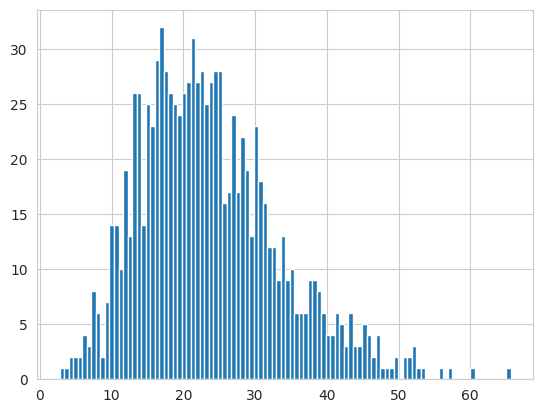

In [47]:
plt.hist(diff_list, bins = 100)
plt.show()

In [48]:
np.mean(diff_list)

23.61151705479622

In [162]:
cppn = CPPN(in_feats = 61, #num_feats + context.shape[0],
                num_layers = 6,
                num_classes = 0,
                num_hidden = 512,
                dropout = 0.4).to(device)
sum(p.numel() for p in cppn.parameters() if p.requires_grad) 

1082881

In [109]:
best_t

0.21

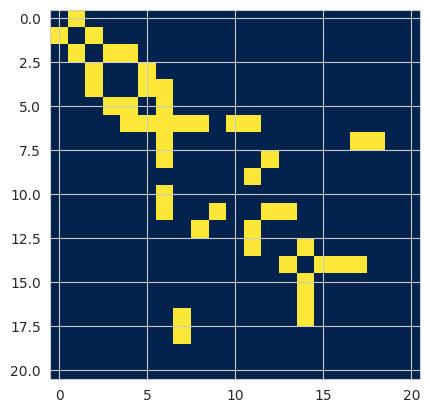

In [56]:
cppn.eval()
out = cppn(in_mat).detach().cpu().numpy().reshape(adj.shape[0], adj.shape[0])
out = (out + out.T) / 2
plt.imshow(out > 0.07 , cmap = 'cividis')# > np.mean(out))
plt.show()

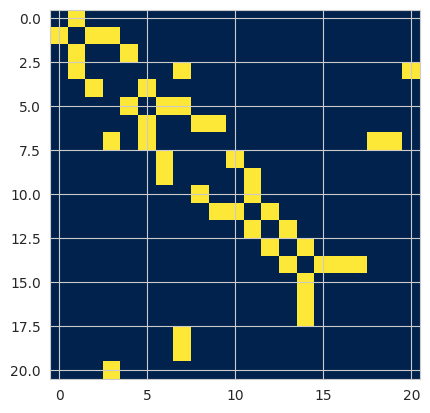

In [50]:
plt.imshow(adj.detach().cpu().numpy(), cmap = 'cividis')